In [19]:
#@title Importing modules
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
#from emcee.autocorr import function_1d
#import emcee
import matplotlib.pyplot as plt
import gillespy2
import os
from scipy.sparse import csr_matrix # For sparse matrices
from typing import List
from scipy.sparse.linalg import expm_multiply
from tqdm.auto import tqdm
#from joblib import Parallel, delayed
import seaborn as sns
import shutil
import matplotlib.ticker as ticker
figSize=800
#import math
import pathlib
#from collections import defaultdict
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)  
# current directory
current_dir = pathlib.Path().absolute()

# if folder_outputs doesnt exist, create it
folder_outputs = current_dir.joinpath('Figures_Exercise_Constitutive')

# Removing directory if exist
if os.path.exists(folder_outputs):
    shutil.rmtree(folder_outputs)
# Creating the directory
folder_outputs.mkdir(parents=True, exist_ok=True)



# Model

| Index | Reaction | Description | Reaction Rate |
|-------|----------|-------------|---------------|
| $r_1$ | $ \xrightarrow[]{k_{r}} R_{n}$ | active gene produces mRNA | $k_{r} $ |
| $r_2$ | $R_{n} \xrightarrow[]{k_{t}} R_{c}$ | mRNA transport to cytoplasm | $k_{t} \cdot [R_{n}]$ |
| $r_3$ | $R_{c} \xrightarrow[]{k_{p}} R_{c} + P$ | mRNA in cytoplasm produces Protein | $k_{p} \cdot [R_{c}]$ |
| $r_4$ | $R_{n} \xrightarrow[]{\gamma_{r}} \phi$ | nuclear mRNA decay | $\gamma_{r} \cdot [R_{n}]$ |
| $r_5$ | $R_{c} \xrightarrow[]{\gamma_{r}} \phi$ | cytoplasm mRNA decay | $\gamma_{r} \cdot [R_{c}]$ |
| $r_6$ | $P \xrightarrow[]{\gamma_p} \phi$ | protein decay | $\gamma_p \cdot [P]$ |



In [20]:
#@title Plotting configuration
plt.rcParams.update({
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
})
# Assign colors to each species for plotting
colors = [ '#FBD148', '#6BCB77', '#AA66CC','#FF6B6B', '#4D96FF']
species_colors = {
    'R_n': colors[2],
    'R_c': colors[3],
    'P':  colors[4]
}

In [21]:
#@title Plotting ODE model
def plotting_deterministic(time,concentrations_species,species_colors,drug_application_time=None,ylim_val=False,save_figure=True,plot_name='det.jpg'):
    plt.figure(figsize=(8, 4))
    for species, color in species_colors.items():
        plt.plot(time, concentrations_species[species], color=color, label=species,lw=4)
    if not drug_application_time is None:
        plt.axvline(x=drug_application_time, color='k', linestyle='--', label= r'$t_{drug}$',lw=1.5)
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title('Deterministic Dynamics')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    if ylim_val:
        plt.ylim(0,ylim_val)
    if save_figure == True: 
        plt.savefig(folder_outputs.joinpath(plot_name), dpi=300, bbox_inches='tight', transparent=True, pad_inches=0.1)  
    plt.show()

In [22]:
def plotting_stochastic(time, trajectories_species,species_colors,drug_application_time=None,ylim_val=False,save_figure=True,plot_name='ssa.jpg'):
    def plot_species_trajectories(time, trajectories_species, species_name, color):
        # Extract the trajectories for the species
        trajectories = trajectories_species[species_name]
        # Calculate the mean and standard deviation across all trajectories
        mean_trajectories = np.mean(trajectories, axis=0)
        std_trajectories = np.std(trajectories, axis=0)
        # Plot mean concentration with standard deviation as shaded area
        plt.plot(time, mean_trajectories, '-', color=color, label=species_name, lw=4)
        plt.fill_between(time, mean_trajectories - std_trajectories, mean_trajectories + std_trajectories, color=color, alpha=0.1)
    plt.figure(figsize=(8, 4))
    # Plot each species
    for species, color in species_colors.items():
        plot_species_trajectories(time, trajectories_species, species, color)
    # Mark the drug application time
    if not drug_application_time is None:
        plt.axvline(x=drug_application_time, color='k', linestyle='--', label=r'$t_{drug}$', lw=1.5)
    # Set plot details
    plt.xlabel('Time')
    plt.ylabel('Number of Molecules')
    plt.title('Stochastic Dynamics')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    if ylim_val:
        plt.ylim(0,ylim_val)
    if save_figure == True: 
        plt.savefig(folder_outputs.joinpath(plot_name), dpi=300, bbox_inches='tight', transparent=False, pad_inches=0.1)  
    plt.show()

In [23]:
def plotting_stochastic_dist(time, trajectories_species, species_name, species_color_dist, time_points, ylim_val=False,save_figure=True,plot_name='ssa_dist.jpg'):
    def plot_species_trajectories(ax, time, trajectories_species, species_name, color, time_point):
        # Extract the trajectories for the species at the specific time point
        trajectories = trajectories_species[species_name][:, time_point]
        # Plot distribution of species count at the specified time point
        ax.hist(trajectories, bins=20, color=color, alpha=0.7, label=f"{species_name} at time={time[time_point]}")
        ax.legend(loc='upper right')
    # Set up a 2x2 subplot grid
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = axs.flatten()  # Flatten the 2x2 array to easily loop over it
    # Plot the species distribution at each of the four user-selected time points
    for i, time_point in enumerate(time_points):
        plot_species_trajectories(axs[i], time, trajectories_species, species_name, species_color_dist, time_point)
        axs[i].set_xlabel('Number of Molecules')
        axs[i].set_ylabel('Frequency')
        if ylim_val:
            axs[i].set_ylim(0, ylim_val)
    # Set a general title
    plt.suptitle(f'Distribution of {species_name} at Different Time Points')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust subplots to fit into the figure area
    if save_figure == True: 
        plt.savefig(folder_outputs.joinpath(plot_name), dpi=300, bbox_inches='tight', transparent=False, pad_inches=0.1)  
    plt.show()

In [24]:
def plotting_stochastic_dist_all_species(time, trajectories_species, species_colors, time_point, ylim_val=False, xlim_vals=None, save_figure=True, plot_name='ssa_dist_all_species.jpg'):
    n_species = len(species_colors)  # Number of species to plot
    n_cols = n_species  # Number of columns in subplot grid
    n_rows = 1
    def plot_species_trajectories(ax, time, trajectories_species, species_name, color, time_point, xlim_val=None):
        def bins_histogram(data):
            if data.max() > 60:
                step_bins =2
            else:
                step_bins=1
            bins = np.arange(np.floor(data.min()), np.ceil(data.max()), step_bins)
            return bins
        # Extract the trajectories for the species at the specific time point
        trajectories = trajectories_species[species_name][:, time_point]
        # Plot distribution of species count at the specified time point
        bins = bins_histogram(trajectories)
        # Plot distribution of species count at the specified time point using defined bins
        ax.hist(trajectories, bins=bins, color=color, alpha=0.7, label=f"{species_name}")  # Label includes species name
        #ax.hist(trajectories, bins=30, color=color, alpha=0.7, label=f"{species_name}") # at time={time[time_point]}")
        ax.legend(loc='upper right')
        ax.set_xlabel('Number of Molecules')
        ax.set_ylabel('Frequency')
        if ylim_val:
            ax.set_ylim(0, ylim_val)
        if xlim_val:  # Set the x-axis limit if specified
            ax.set_xlim(xlim_val)
    # Set up subplot grid
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows), squeeze=False)
    axs = axs.flatten()  # Flatten the array to easily loop over it
    # Plot the species distribution at the selected time point
    for i, (species_name, species_color) in enumerate(species_colors.items()):
        xlim_val = xlim_vals.get(species_name, None) if xlim_vals else None  # Get the x-axis limit for the species if specified
        plot_species_trajectories(axs[i], time, trajectories_species, species_name, species_color, time_point, xlim_val)
    for ax in axs[i+1:]:  # Hide unused subplots
        ax.set_visible(False)
    # Set a general title
    plt.suptitle(f'Distribution of Species at Time={time[time_point]}',fontsize=20 )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_figure == True: 
        plt.savefig(folder_outputs.joinpath(plot_name), dpi=300, bbox_inches='tight', transparent=False, pad_inches=0.1)  
    plt.show()
        


In [25]:
def plotting_combined(time, trajectories_species, species_colors, drug_application_time=None, ylim_val=None, time_point=10, save_figure=True, plot_name='ssa_tc_dist.jpg'):
    # Create a single row with four columns
    fig, axs = plt.subplots(1, 4, figsize=(18, 4), squeeze=False)
    axs = axs.flatten()  # Flatten the array for easier indexing
    def plot_time_courses(ax, time, trajectories_species, species_colors, drug_application_time):
        # Assuming trajectories_species is a list of dicts, each dict representing a single "trajectory" 
        # and keys are species names pointing to a 2D array (trajectories, time points)
        for species_name, color in species_colors.items():
            # Aggregate data across all trajectories for the species
            all_trajectories = np.vstack([trajectory[species_name] for trajectory in trajectories_species])
            mean_trajectories = np.mean(all_trajectories, axis=0)
            std_trajectories = np.std(all_trajectories, axis=0)
            ax.plot(time, mean_trajectories, '-', color=color, label=species_name, lw=2)
            ax.fill_between(time, mean_trajectories - std_trajectories, mean_trajectories + std_trajectories, color=color, alpha=0.1)
            if drug_application_time is not None:
                ax.axvline(x=drug_application_time, color='k', linestyle='--', label='Drug application', lw=1.5)
            ax.set_xlabel('Time')
            ax.set_ylabel('Number of Molecules')
            ax.legend(loc='upper right', fontsize=14)
            ax.set_title('Time Courses for All Species')
            if ylim_val:
                ax.set_ylim(0, ylim_val)
    def plot_species_distribution(ax, time, trajectories_species, species_name, color, time_point):
        def bins_histogram(data):
            if data.max() > 60:
                step_bins =2
            else:
                step_bins=1
            bins = np.arange(np.floor(data.min()), np.ceil(data.max()), step_bins)
            return bins
        # Aggregate data across all trajectories for the species at the specified time point
        all_trajectories_at_time_point = np.hstack([trajectory[species_name][ time_point] for trajectory in trajectories_species])
        bins = bins_histogram(all_trajectories_at_time_point)
        ax.hist(all_trajectories_at_time_point, bins=bins, color=color, alpha=0.7, label=f"{species_name}")
        ax.legend(loc='upper right')
        ax.set_xlabel('Number of Molecules')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution at Time={time[time_point]}')
    # Plot time courses in the first subplot
    plot_time_courses(axs[0], time, trajectories_species, species_colors, drug_application_time)
    species_list = list(species_colors.keys())
    # Assume up to three additional species for distribution plots
    for i, species_name in enumerate(species_list[:3]):  # Limit to three species
        plot_species_distribution(axs[i + 1], time, trajectories_species, species_name, species_colors[species_name], time_point)
    # Adjust remaining subplots if fewer than three species are provided
    for j in range(i + 2, 4):
        axs[j].set_visible(False)
    plt.tight_layout()
    if save_figure:
        plt.savefig(folder_outputs.joinpath(plot_name), dpi=300, bbox_inches='tight', transparent=False, pad_inches=0.1)  
    plt.show()

In [26]:
class GeneExpressionModel(gillespy2.Model):
    def __init__(self, parameter_values, initial_conditions, mode='continuous'):
        super().__init__('GeneExpressionModel')
        # Add parameters from the dictionary to the model
        for name, expression in parameter_values.items():
            self.add_parameter(gillespy2.Parameter(name=name, expression=expression))
        # Define species with initial conditions and add them to the model
        species_list = [
            gillespy2.Species(name='R_n', initial_value=initial_conditions.get('R_n', 0), mode=mode),
            gillespy2.Species(name='R_c', initial_value=initial_conditions.get('R_c', 0), mode=mode),
            gillespy2.Species(name='P', initial_value=initial_conditions.get('P', 0), mode=mode)
        ]
        self.add_species(species_list)
        # Define reactions and add them to the model
        reactions = [
            gillespy2.Reaction(name='mRNA_production', reactants={}, products={species_list[0]: 1}, rate=self.listOfParameters['k_r']),
            gillespy2.Reaction(name='mRNA_transport', reactants={species_list[0]: 1}, products={species_list[1]: 1}, rate=self.listOfParameters['k_t']),
            gillespy2.Reaction(name='protein_production', reactants={species_list[1]: 1}, products={species_list[1]: 1, species_list[2]: 1}, rate=self.listOfParameters['k_p']),
            gillespy2.Reaction(name='nuclear_mRNA_decay', reactants={species_list[0]: 1}, products={}, rate=self.listOfParameters['gamma_r']),
            gillespy2.Reaction(name='cytoplasm_mRNA_decay', reactants={species_list[1]: 1}, products={}, rate=self.listOfParameters['gamma_r']),
            gillespy2.Reaction(name='protein_decay', reactants={species_list[2]: 1}, products={}, rate=self.listOfParameters['gamma_p'])
        ]
        self.add_reaction(reactions)
        # Define the simulation time span
        self.timespan(np.linspace(0, 100, 101))

def initialize_model(parameter_values, initial_conditions, mode='continuous', apply_drug=False, inhibited_parameters=None):
    model = GeneExpressionModel(parameter_values, initial_conditions, mode=mode)
    for species in model.listOfSpecies.values():
        species.mode = mode
    if apply_drug and inhibited_parameters is not None:
        for param, value in inhibited_parameters.items():
            if param in model.listOfParameters:
                model.listOfParameters[param].expression = str(value)
    return model

def run_simulation_phase(model_initializer, parameter_values, initial_conditions, simulation_end, number_of_trajectories, apply_drug=False, inhibited_parameters=None, simulation_type='discrete', burn_in_time=None):
    model = model_initializer(parameter_values, initial_conditions, mode=simulation_type, apply_drug=apply_drug, inhibited_parameters=inhibited_parameters)
    total_timespan = np.linspace(0, simulation_end, num=int(simulation_end) + 1)
    model.timespan(total_timespan)
    if simulation_type == 'discrete':
        results = model.run(solver=gillespy2.TauLeapingSolver, number_of_trajectories=number_of_trajectories)
        list_all_results = []
        for n in range(number_of_trajectories):
            species_trajectories = {species: results[n][species] for species in model.listOfSpecies.keys()}
            if burn_in_time is not None:
                burn_in_index = burn_in_time if burn_in_time < len(total_timespan) else len(total_timespan) - 1
                species_trajectories = {species: species_trajectories[species][burn_in_index:] for species in model.listOfSpecies.keys()}
            list_all_results.append(species_trajectories)
        return list_all_results
    else:
        result = model.run(solver=gillespy2.ODESolver)
        if burn_in_time is not None:
            trajectories_species = {species: result[0][species][burn_in_time:] for species in model.listOfSpecies.keys()}
        else:
            trajectories_species = {species: result[0][species] for species in model.listOfSpecies.keys()}
        return trajectories_species



In [27]:
def simulate_model(parameter_values, initial_conditions, total_simulation_time, simulation_type, burn_in_time=None, drug_application_time=None, inhibited_parameters=None, number_of_trajectories=1):
    """
    Simulate a model either as deterministic or stochastic based on user input,
    including optional burn-in and drug application phases.
    """
    # Determine the end time for the initial simulation phase
    # This phase may include the burn-in period (if any) and extends up to the drug application time or the total simulation time
    if burn_in_time is None or burn_in_time < 50:
        burn_in_time = None
    if burn_in_time is not None:
        end_time_initial_phase = drug_application_time + burn_in_time if drug_application_time is not None else total_simulation_time+burn_in_time
    else:
        end_time_initial_phase = drug_application_time if drug_application_time is not None else total_simulation_time
    # The run_simulation_phase function will only return results after the burn-in period, adjusting the timespan accordingly
    trajectories_initial = run_simulation_phase( initialize_model, parameter_values=parameter_values, initial_conditions=initial_conditions, simulation_end=end_time_initial_phase, number_of_trajectories=number_of_trajectories, apply_drug=False,inhibited_parameters= None, simulation_type=simulation_type, burn_in_time=burn_in_time)  
    # If there's a drug application phase
    if drug_application_time is not None:
        drug_simulation_end = total_simulation_time - drug_application_time
        if simulation_type == 'continuous':
            updated_initial_conditions = {species: trajectories_initial[species][-1] for species in trajectories_initial}
            trajectories_drug = run_simulation_phase( initialize_model, parameter_values=parameter_values, initial_conditions=updated_initial_conditions, simulation_end=drug_simulation_end, number_of_trajectories=1, apply_drug=True, inhibited_parameters=inhibited_parameters, simulation_type=simulation_type)
            trajectories_species = {species: np.concatenate([trajectories_initial[species], trajectories_drug[species][1:]])
                                    for species in trajectories_initial}
        else:
            all_results_after_drug = []
            for i in range(number_of_trajectories):
                updated_initial_conditions = {species: trajectories_initial[i][species][-1] for species in trajectories_initial[i].keys()}
                trajectories_drug = run_simulation_phase( initialize_model, parameter_values=parameter_values, initial_conditions=updated_initial_conditions, simulation_end=drug_simulation_end, number_of_trajectories=1, apply_drug=True, inhibited_parameters=inhibited_parameters, simulation_type=simulation_type)
                all_results_after_drug.append(trajectories_drug[0])
            # append the results from the first phase to the results from the second phase
            trajectories_species = {}
            #if len(trajectories_initial) > 0 and len(all_results_after_drug) > 0:
            for species in trajectories_initial[0].keys():
                species_data_across_trajectories = []
                for i in range(number_of_trajectories):
                    initial_data = trajectories_initial[i][species]
                    after_drug_data = all_results_after_drug[i][species]
                    concatenated_data = np.concatenate([initial_data[:-1], after_drug_data])
                    species_data_across_trajectories.append(concatenated_data)
                trajectories_species[species] = np.stack(species_data_across_trajectories)
    else:
        trajectories_species = trajectories_initial
    # creating a vector for time span
    time = np.linspace(0, total_simulation_time, num=total_simulation_time + 1)
    return time, trajectories_species

## Adjusting $(k_t)$ to Incorporate Diffusion and Transport Rates from Simulated Cell Model

To adjust the parameter $(k_t)$, accounting for both the diffusion rate $(k_{diff_r})$ and the transport rate $(transport\_rate)$ from from Simulated Cell Model, we follow a multi-step process. This process aims to encapsulate the combined effects of RNA diffusion to the nuclear envelope and its subsequent transport into the cytosol.

### Step 1: Effective Diffusion Time $(T_{diff})$

First, we estimate the effective time $(T_{diff})$ it takes for an RNA molecule to diffuse to the nuclear envelope. Assuming a known average distance $(D)$ to the nuclear envelope, and given the diffusion rate $(k_{diff_r})$, the diffusion time can be approximated as:

$$T_{diff} = \frac{D^2}{2 \cdot k_{diff_r}}$$

This formula simplifies the complexity of cellular environments and assumes a direct, unobstructed path to the nuclear envelope.

### Step 2: Effective Transport Time $(T_{transport})$

Next, we define the effective time $(T_{transport})$ for RNA to be transported across the nuclear envelope, utilizing the transport rate $(transport\_rate)$:

$$T_{transport} = \frac{1}{transport\_rate}$$

### Step 3: Combining Effective Times

The total effective time $(T_{total})$ for an RNA molecule to move from the nucleus to the cytosol combines both diffusion and transport times:

$$T_{total} = T_{diff} + T_{transport}$$

### Step 4: Calculating Effective Rate $(k_t)$

Finally, we calculate an effective rate $(k_t)$ for RNA transport from the nucleus to the cytosol in Model 1, reflecting both diffusion and transport:

$$k_t = \frac{1}{T_{total}} = \frac{1}{\frac{D^2}{2 \cdot k_{diff_r}} + \frac{1}{transport\_rate}}$$

This equation provides a way to adjust $(k_t)$ in Model 1 to more accurately reflect the complex process of RNA movement within the cell, considering both its diffusion to the nuclear envelope and the subsequent transport into the cytosol.



In [28]:
def calculate_effective_kt(D, k_diff_r, transport_rate, model_type):
    """
    Calculate the effective rate (k_t) for RNA transport from the nucleus to the cytosol,
    incorporating the effects of diffusion to the nuclear envelope and transport across it,
    adjusted for the dimensionality of the simulation (2D or 3D).

    Parameters:
    - D (float): Distance to the nuclear envelope (assumed to be in the same units as used for k_diff_r).
    - k_diff_r (float): Diffusion rate of RNA to the nuclear envelope.
    - transport_rate (float): Rate of RNA transport from the nucleus to the cytosol.
    - model_type: The dimensionality of the simulation (2D or 3D).

    Returns:
    - k_t (float): Effective rate of RNA transport from nucleus to cytosol.
    """
    # converting diameter to radius
    D = D/2
    # Adjust the diffusion calculation based on dimensionality
    if model_type == '2D':
        # In 2D, diffusion might be more efficient due to less volume to cover
        T_diff = D**2 / (4 * k_diff_r)  # Adjusted for 2D
    elif model_type == '3D':
        # In 3D, diffusion covers more volume
        T_diff = D**2 / (6 * k_diff_r)  # Adjusted for 3D
    else:
        raise ValueError("Dimension must be 2 or 3.")

    # Calculate T_transport as the inverse of transport_rate
    T_transport = 1 / transport_rate
    
    # Calculate the total effective time (T_total)
    T_total = T_diff + T_transport
    
    # Calculate the effective rate (k_t) as the inverse of T_total
    k_t = 1 / T_total
    
    return k_t


# Solving unperturbed moodel
___

In [29]:
# Model Parameters
k_r = 2
k_p = 0.5
gamma_r = 0.05 # assuming gamma_rn = gamma_rc
gamma_p = 0.25
transport_rate = 0.5

diffusion_rate = 10 # assuming diffusion_rate_r = diffusion_rate_p
total_simulation_time = 201
nucleus_diameter = 40
number_of_trajectories = 100

cytosol_diameter = 70 
model_type = '2D'


# Calculating effective transport rate
effective_k_t = calculate_effective_kt(D=nucleus_diameter, k_diff_r=diffusion_rate, transport_rate=transport_rate, model_type=model_type) 
print('Effective transport rate: ', effective_k_t)
kt = effective_k_t
drug_application_time = None
inhibited_parameters=None
# Parameters for plotting
max_y_val =65
# adding burnin time to allow the system to reach steady state
burn_in_time = 0


Effective transport rate:  0.08333333333333333


In [30]:
# Model Parameters and initial conditions as dictionaries

parameter_values = {
            'k_r': k_r,
            'k_t': kt,
            'k_p': k_p,
            'gamma_r': gamma_r,
            'gamma_p': gamma_p,
        }

initial_conditions = {
    'R_n': 0,
    'R_c': 0,
    'P' : 0
}


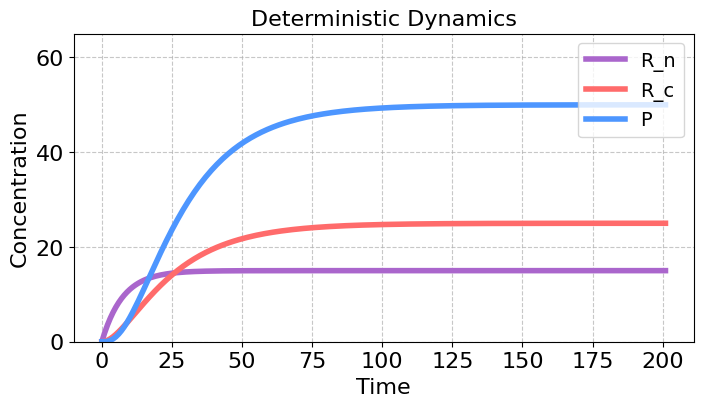

In [31]:
# Running the ODE model
time, concentrations_species =simulate_model(parameter_values, 
                                             initial_conditions, 
                                             total_simulation_time, 
                                             simulation_type='continuous', 
                                             burn_in_time=burn_in_time, 
                                             drug_application_time=drug_application_time, 
                                             inhibited_parameters=inhibited_parameters,
                                             )
plotting_deterministic(time,concentrations_species,species_colors,ylim_val=max_y_val,save_figure=True,)

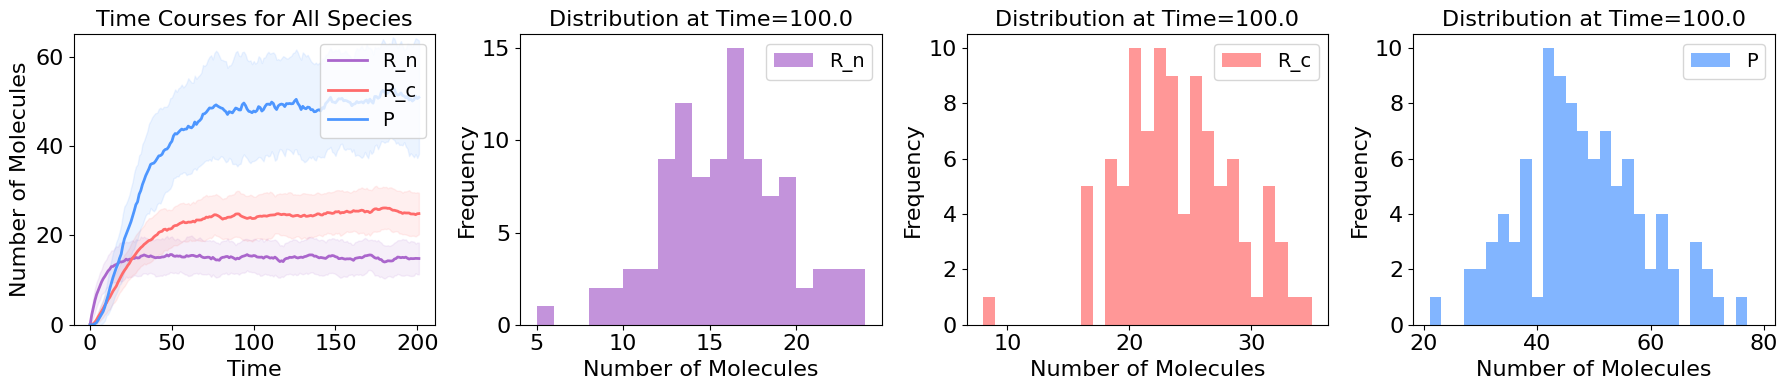

In [32]:
# Running SSA
time,trajectories_species  = simulate_model(parameter_values,
                                                  initial_conditions,
                                                  total_simulation_time,
                                                  simulation_type='discrete', 
                                                  burn_in_time=burn_in_time,
                                                  drug_application_time=drug_application_time,
                                                  inhibited_parameters=inhibited_parameters,
                                                  number_of_trajectories=number_of_trajectories)
plotting_combined(time, trajectories_species, species_colors,drug_application_time, time_point=100,ylim_val=max_y_val,save_figure=True,plot_name='ssa_combined.jpg')

# Solving the model after drug application
____

In [33]:
# Model Parameters
drug_application_time = 120
inhibition_constant = 0.1
inhibited_parameters={'k_t': effective_k_t*inhibition_constant}

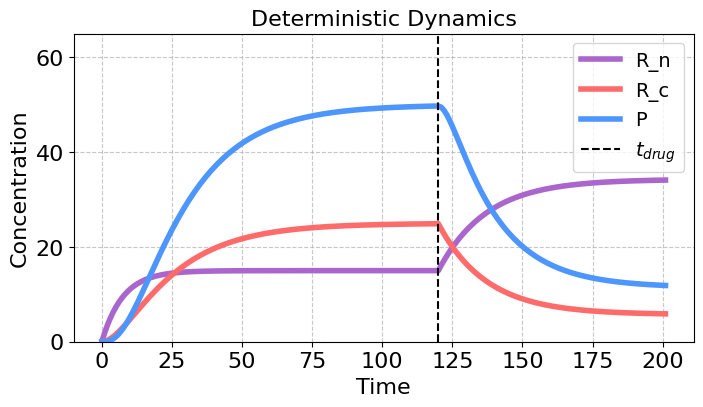

In [34]:
# Running the ODE model
time, concentrations_species = simulate_model(parameter_values,
                                                      initial_conditions,
                                                      total_simulation_time,
                                                      simulation_type='continuous', 
                                                      burn_in_time=burn_in_time,
                                                      drug_application_time=drug_application_time,
                                                      inhibited_parameters=inhibited_parameters)
plotting_deterministic(time,concentrations_species,species_colors,drug_application_time,ylim_val=max_y_val,save_figure=True,plot_name='det_inhibition.jpg')

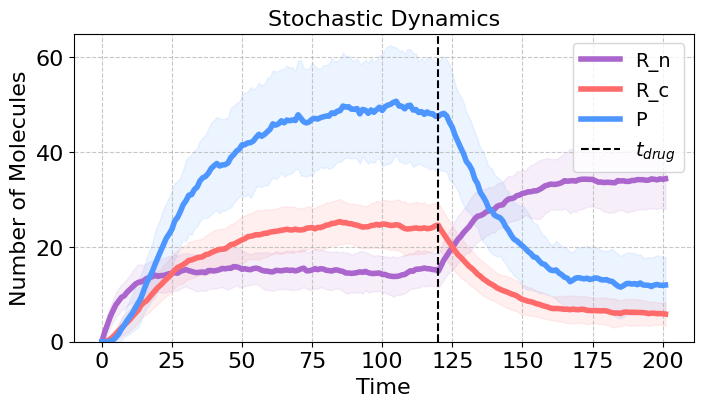

In [35]:
# Running SSA
time, trajectories_species = simulate_model(parameter_values,
                                                  initial_conditions,
                                                  total_simulation_time,
                                                  simulation_type='discrete', 
                                                  burn_in_time=burn_in_time,
                                                  drug_application_time=drug_application_time,
                                                  inhibited_parameters=inhibited_parameters,
                                                  number_of_trajectories=number_of_trajectories)
plotting_stochastic(time, trajectories_species,species_colors,drug_application_time,ylim_val=max_y_val,save_figure=True,plot_name='ssa_inhibition.jpg')

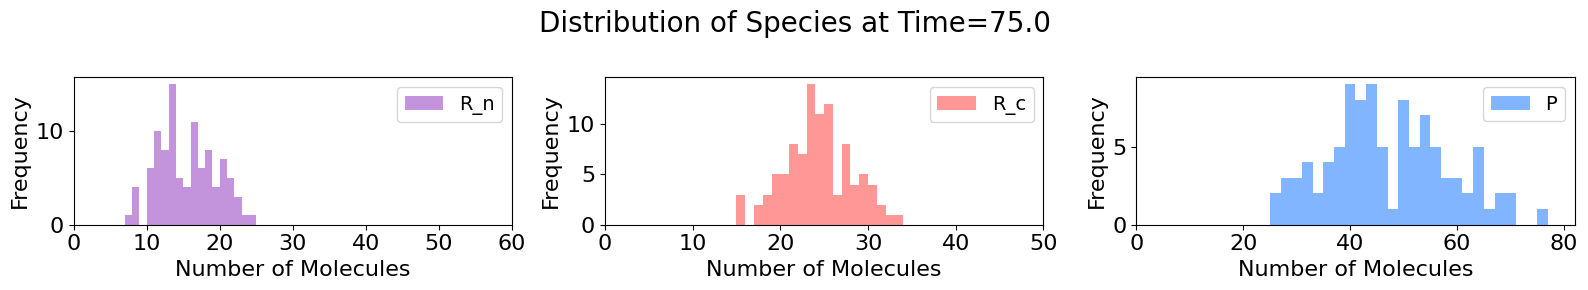

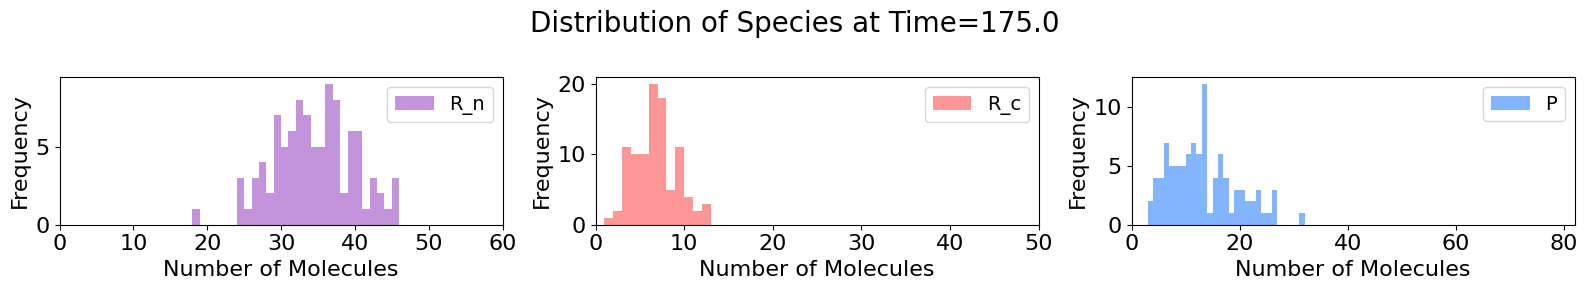

In [36]:
xlim_vals = { 'R_n': (0,60), 'R_c':(0,50), 'P': (0, 82)}  # Example x-axis limits for each species
plotting_stochastic_dist_all_species(time, trajectories_species, species_colors, time_point=75, xlim_vals=xlim_vals)
plotting_stochastic_dist_all_species(time, trajectories_species, species_colors, time_point=175, xlim_vals=xlim_vals)
